# Setup

In [49]:
# Imports 
import io
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as st


# Golf putting data from Berry (1996)
golf_data = """distance tries successes
2 1443 1346
3 694 577
4 455 337
5 353 208
6 272 149
7 256 136
8 240 111
9 217 69
10 200 67
11 237 75
12 202 52
13 192 46
14 174 54
15 167 28
16 201 27
17 195 31
18 191 33
19 147 20
20 152 24"""


# Helper functions
def plot_golf_data(golf_data, ax=None):
    """Utility function to standardize a pretty plotting of the golf data.
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 6))
    bg_color = ax.get_facecolor()
    ax.plot(golf_data["distance"], golf_data["successes"] / golf_data["tries"], 'o', mfc=bg_color, label=None)

    ax.set_xlabel("Distance from hole")
    ax.set_ylabel("Proportion of putts made")
    ax.set_ylim(bottom=0, top=1)

    ax.set_xlim(left=0)
    ax.grid(True, axis='y', alpha=0.7)
    return ax

## Data

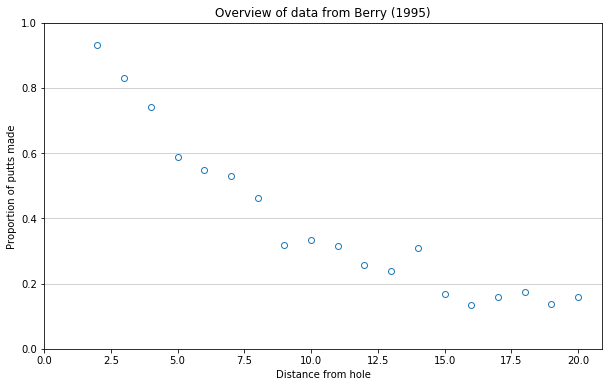

In [28]:
data = pd.read_csv(io.StringIO(golf_data), sep=" ")
ax = plot_golf_data(data)
ax.set_title("Overview of data from Berry (1995)")
plt.show()

# Baseline: Logit model

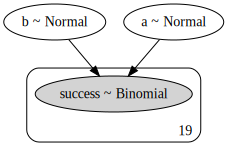

In [45]:
def logit_model(golf_data):
    """Logistic regression model."""
    with pm.Model() as logit_binomial:
        # Priors
        a = pm.Normal('a', mu=0, tau=1)
        b = pm.Normal('b', mu=0, tau=1)

        # Logit link
        link = pm.math.invlogit(a + b*golf_data["distance"])
        
        # Likelihood
        success = pm.Binomial(
            'success',
            n=golf_data["tries"],
            p=link,
            observed=golf_data["successes"]
        )
    return logit_binomial

# Visualise model
pm.model_to_graphviz(logit_model(data))

In [46]:
# Sampling from posterior
with logit_model(data):
    logit_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 5918.47draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [47]:
pm.summary(logit_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,2.222,0.059,2.107,2.330,0.002,0.001,793.0,793.0,795.0,1310.0,1.01
b,-0.255,0.007,-0.268,-0.242,0.000,0.000,818.0,818.0,821.0,1350.0,1.01


100%|██████████| 500/500 [00:00<00:00, 1666.88it/s]


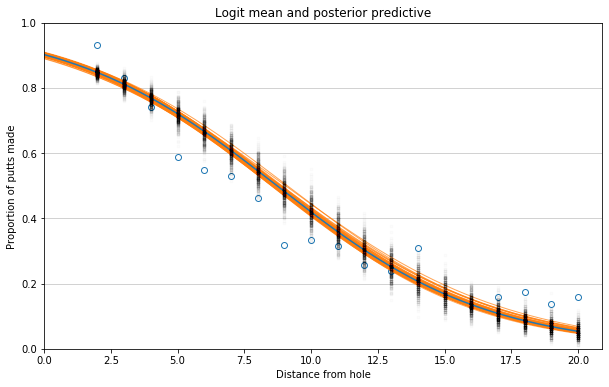

In [65]:
# Draw posterior predictive samples
with logit_model(data):
    logit_ppc = pm.sample_posterior_predictive(logit_trace, samples=500)

logit_ppc_success = logit_ppc["success"].T / data["tries"].values.reshape(-1, 1)

# Plotting
ax = plot_golf_data(data)
distances = np.linspace(0, data["distance"].max(), 200)

# Plotting individual predicted sigmoids for draws of (a, b)
for idx in np.random.randint(0, len(logit_trace), 50):
    ax.plot(
        distances,
        scipy.special.expit(logit_trace["a"][idx] + logit_trace["b"][idx] * distances),
        lw=1,
        color='tab:orange',
        alpha=.7,
    )
    
# Plotting average prediction over all sampled (a, b)
ax.plot(
    distances,
    scipy.special.expit(logit_trace["a"].reshape(-1, 1) + logit_trace["b"].reshape(-1, 1) * distances).mean(axis=0),
    color='tab:blue',
)

# Plotting posterior predictive proportion of successes
ax.plot(data["distance"], logit_ppc_success, 'k.', alpha=0.01)
ax.set_title('Logit mean and posterior predictive');